In [1]:
import math
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, LambdaCallback
# utils 中的调用

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Masking,Dropout,Layer,Permute,Reshape,Lambda,RepeatVector,Flatten
# model 中的调用

import sys
sys.path.append('E:\study\复现资料\RUL-RVE\SIMPAC-2022-58-main')#The path of the utils.py,utils.py file has been uploaded
import utils

In [2]:
dataset = "FD001"

sensors = ['s_{}'.format(i + 1) for i in range(0, 21)]
# windows length
sequence_length = 30
# smoothing intensity
alpha = 0.1
# max RUL
threshold = 125

x_train, y_train, x_val, y_val, x_test, y_test = utils.get_data(dataset, sensors, sequence_length, alpha, threshold)

E:\study\复现资料\RUL-RVE\SIMPAC-2022-58-main\utils.py:60: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(level=0,
E:\study\复现资料\RUL-RVE\SIMPAC-2022-58-main\utils.py:60: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., grou

In [3]:
# Setup the network parameters:
timesteps = x_train.shape[1]
input_dim = x_train.shape[2]
intermediate_dim = 300
batch_size = 128
latent_dim = 2
epochs = 15
# used to mask values in sequences with less than 30 cycles until 30 is reached
masking_value = -99.

In [4]:
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, timesteps))(a)
    a = Dense(timesteps, activation='softmax')(a)
    a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
    a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = tf.keras.layers.multiply([inputs, a_probs], name='attention_mul')
    return output_attention_mul


class Sampling(keras.layers.Layer):
    """Uses (z_mean, sigma) to sample z, the vector encoding an engine trajetory."""
    def call(self, inputs):
        mu, sigma = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * sigma) * epsilon

In [5]:
# ----------------------- Encoder -----------------------
inputs = Input(shape=(timesteps, input_dim,), name='encoder_input')
mask = Masking(mask_value=masking_value)(inputs)

# LSTM encoding
lstm_out = Bidirectional(LSTM(intermediate_dim,return_sequences=True))(mask) 
attention_out = attention_3d_block(lstm_out)
attention_mul = Flatten()(attention_out)


# VAE Z layer
mu = Dense(latent_dim)(attention_mul)
sigma = Dense(latent_dim)(attention_mul)

z = Sampling()([mu, sigma])

# Instantiate the encoder model:
encoder = keras.Model(inputs, [mu, sigma, z], name='encoder')
print(encoder.summary())
# -------------------------------------------------------

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 30, 21)]     0           []                               
                                                                                                  
 masking (Masking)              (None, 30, 21)       0           ['encoder_input[0][0]']          
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 600)      772800      ['masking[0][0]']                
                                                                                                  
 permute (Permute)              (None, 600, 30)      0           ['bidirectional[0][0]']          
                                                                                            

In [7]:
# ----------------------- Regressor --------------------
reg_latent_inputs = Input(shape=(latent_dim), name='z_sampling_reg')

reg_intermediate1 = Dense(200)(reg_latent_inputs)

#reg_dropout = Dropout(0.3)(reg_intermediate1)
reg_outputs = Dense(1,name='reg_output')(reg_intermediate1)
# Instantiate the classifier model:
regressor = keras.Model(reg_latent_inputs, reg_outputs, name='regressor')
print(regressor.summary())
# -------------------------------------------------------

Model: "regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling_reg (InputLayer)  [(None, 2)]              0         
                                                                 
 dense_4 (Dense)             (None, 200)               600       
                                                                 
 reg_output (Dense)          (None, 1)                 201       
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
class VAR(keras.Model):
    def __init__(self, encoder, regressor, decoder=None, **kwargs):
        super(VAR, self).__init__(**kwargs)
        self.encoder = encoder
        self.regressor = regressor
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reg_loss_tracker = keras.metrics.Mean(name="reg_loss")
        self.decoder = decoder
        if self.decoder!=None:
            self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        

    @property
    def metrics(self):
        if self.decoder!=None:
            return [
                self.total_loss_tracker,
                self.kl_loss_tracker,
                self.reg_loss_tracker,
                self.reconstruction_loss_tracker
            ]
        else:
            return [
                self.total_loss_tracker,
                self.kl_loss_tracker,
                self.reg_loss_tracker,
            ]

    def train_step(self, data):
        x, target_x = data
        with tf.GradientTape() as tape:
            # kl loss
            mu, sigma, z = self.encoder(x)
            kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            # Regressor
            reg_prediction = self.regressor(z)
            reg_loss = tf.reduce_mean(
                keras.losses.mse(target_x, reg_prediction)
            )
            # Reconstruction
            if self.decoder!=None:
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.reduce_mean(
                    keras.losses.mse(x, reconstruction)
                )
                total_loss = kl_loss + reg_loss + reconstruction_loss
                self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            else:
                total_loss = kl_loss + reg_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reg_loss": self.reg_loss_tracker.result(),
        }


    def test_step(self, data):
        x, target_x = data

        # kl loss
        mu, sigma, z = self.encoder(x)
        kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        # Regressor
        reg_prediction = self.regressor(z)
        reg_loss = tf.reduce_mean(
            keras.losses.mse(target_x, reg_prediction)
        )
        # Reconstruction
        if self.decoder!=None:
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mse(x, reconstruction)
            )
            
            total_loss = kl_loss + reg_loss + reconstruction_loss
        else:
            total_loss = kl_loss + reg_loss

        return {
            "loss": total_loss,
            "kl_loss": kl_loss,
            "reg_loss": reg_loss,
        }


In [9]:
class save_latent_space_viz(Callback):
    def __init__(self, model, data, target):
        self.model = model
        self.data = data
        self.target = target

    def on_train_begin(self, logs={}):
        self.best_val_loss = 100000

    def on_epoch_end(self, epoch, logs=None):
        encoder = self.model.layers[0]
        if logs.get('val_loss') < self.best_val_loss:
            self.best_val_loss = logs.get('val_loss')
            viz_latent_space(encoder, self.data, self.target, epoch, True, False)


In [12]:
def get_callbacks(model, data, target):
    model_callbacks = [
        EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15),
        ModelCheckpoint(filepath='E:\study\复现资料\RUL estimation experiment\会议实验checkpoints/checkpoint', monitor='val_loss', mode='min', verbose=1,
                        save_best_only=True, save_weights_only=True)
    ]
    return model_callbacks

In [13]:
vae = VAR(encoder, regressor)
model_callbacks = get_callbacks(vae, x_train, y_train)

In [14]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
History = vae.fit(x_train, y_train,epochs=epochs,callbacks=model_callbacks,validation_data=(x_val, y_val), batch_size=batch_size)

Epoch 1/15
112/112 [==============================] - ETA: 0s - loss: 5067.9348 - kl_loss: 321.7066 - reg_loss: 2523.9946
Epoch 1: val_loss improved from inf to 49.67239, saving model to E:\study\复现资料\RUL estimation experiment\会议实验checkpoints\checkpoint
112/112 [==============================] - 59s 463ms/step - loss: 5048.2691 - kl_loss: 321.7066 - reg_loss: 2523.9946 - val_loss: 49.6724 - val_kl_loss: 17.2393 - val_reg_loss: 32.4331
Epoch 2/15
112/112 [==============================] - ETA: 0s - loss: 777.8872 - kl_loss: 200.7434 - reg_loss: 485.9698
Epoch 2: val_loss improved from 49.67239 to 24.78791, saving model to E:\study\复现资料\RUL estimation experiment\会议实验checkpoints\checkpoint
112/112 [==============================] - 55s 494ms/step - loss: 777.0804 - kl_loss: 200.7434 - reg_loss: 485.9698 - val_loss: 24.7879 - val_kl_loss: 9.6324 - val_reg_loss: 15.1555
Epoch 3/15
112/112 [==============================] - ETA: 0s - loss: 502.5591 - kl_loss: 109.3768 - reg_loss: 333.9849
Ep

In [13]:
vae.load_weights('E:\study\复现资料\RUL estimation experiment\会议实验checkpoints/checkpoint')#提取最优Val_Loss进行预测

dict_keys(['loss', 'kl_loss', 'reg_loss', 'val_loss', 'val_kl_loss', 'val_reg_loss'])


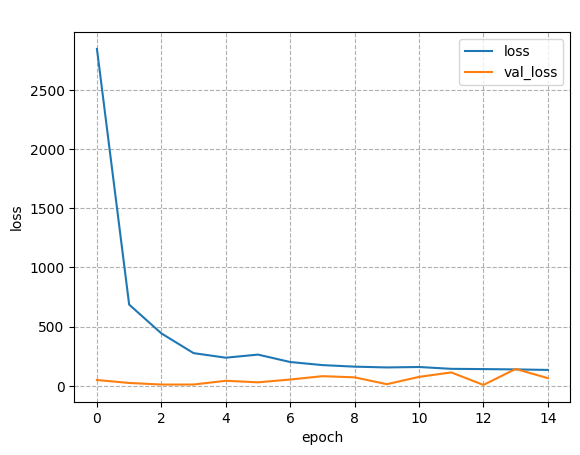

In [15]:
def plotTrainHistory(model,title=' '):
    plt.grid(linestyle="--")
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    
    plt.show()
    
print(History.history.keys())
plotTrainHistory(History)

555/555 [==============================] - 36s 60ms/step


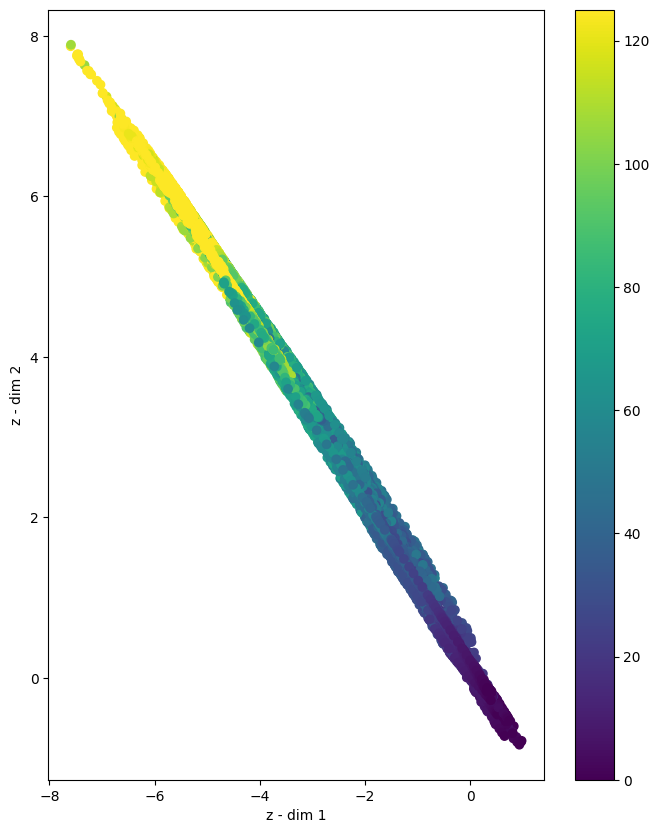

4/4 [==============================] - 0s 47ms/step


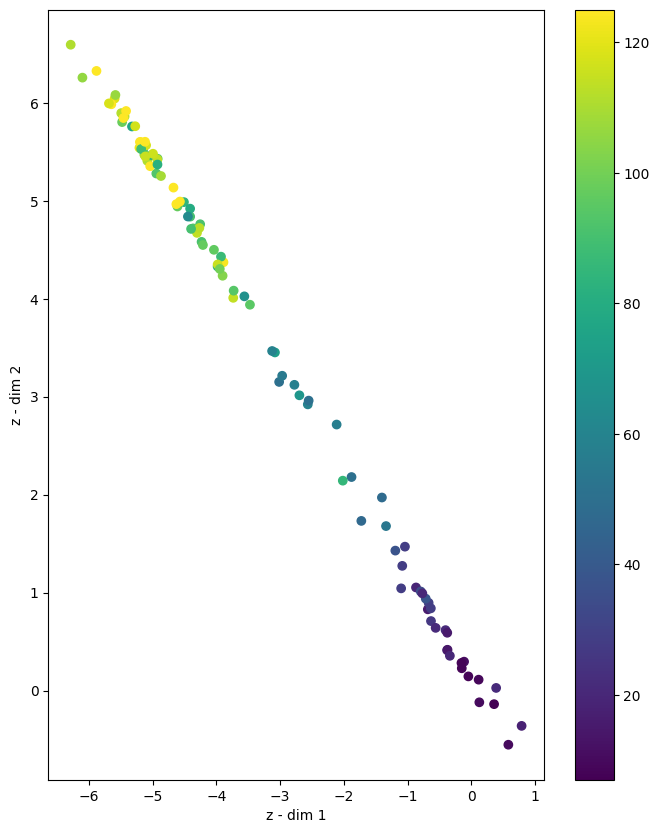

In [16]:
train_mu = utils.viz_latent_space(vae.encoder, np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
test_mu = utils.viz_latent_space(vae.encoder, x_test, y_test)


In [17]:
# Evaluate
y_hat_train = vae.regressor.predict(train_mu)
y_hat_test = vae.regressor.predict(test_mu)

utils.evaluate(np.concatenate((y_train, y_val)), y_hat_train, 'train')
RMSE=utils.evaluate(y_test, y_hat_test, 'test')
score=utils.score(y_test, y_hat_test)

4/4 [==============================] - 0s 0s/step
train set RMSE:11.493968963623047, R2:0.9243884545260105
test set RMSE:15.300709479334255, R2:0.8542148025469167
score:  500.5990105867386


In [19]:
argsort=np.argsort(y_test)
y_test1=y_test[argsort]
y_hat_test1=y_hat_test[argsort]

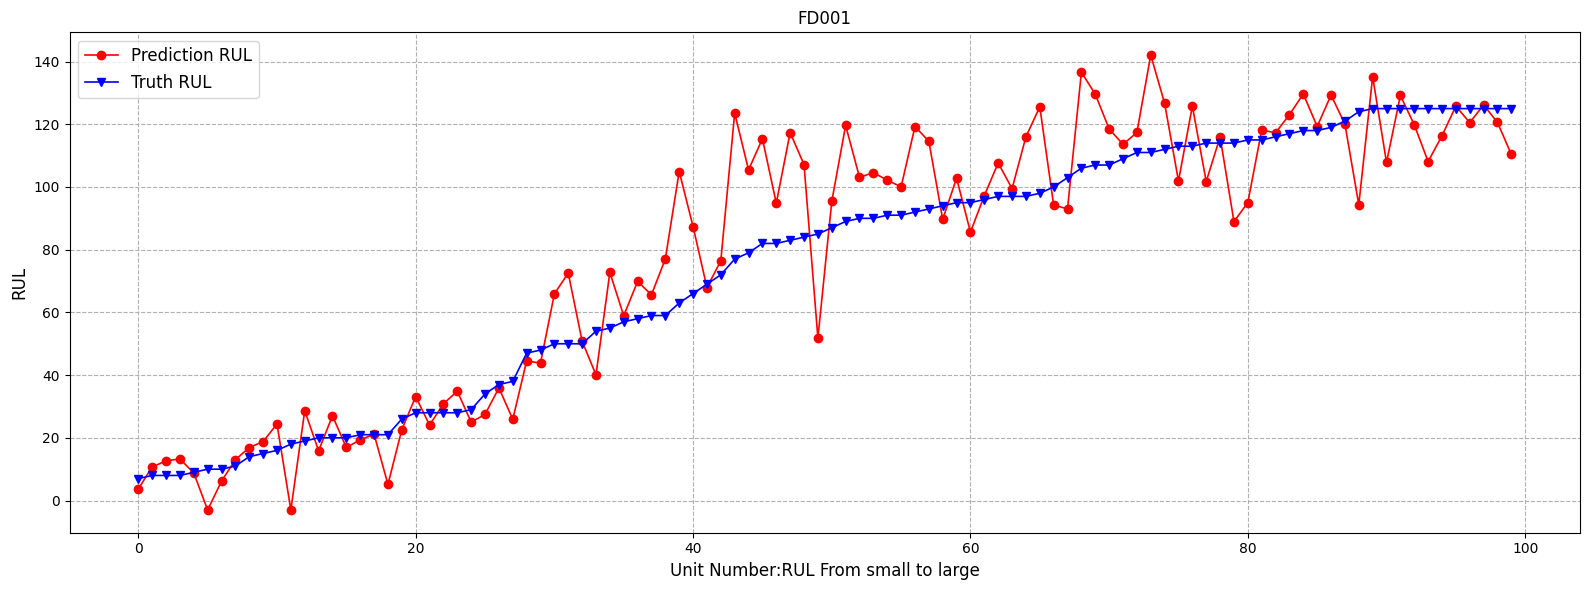

In [20]:
"""测试集所有unitNumber的最后一个值进行可视化"""
from sklearn.metrics import mean_squared_error

fig=plt.figure(figsize=(16,6))
plt.grid(linestyle="--")
plt.plot(y_hat_test1, color='red', label='Prediction RUL', marker='o',linestyle='-',linewidth=1.2)
plt.plot(y_test1, color='blue', label='Truth RUL', marker='v',linestyle='-',linewidth=1.2)
plt.title(dataset,fontsize=12)
plt.ylabel('RUL',fontsize=12)
plt.xlabel('Unit Number:RUL From small to large' ,fontsize=12)
plt.legend(loc='upper left',fontsize=12)
fig.tight_layout()
#plt.savefig(save_dir+'FD001_Last_point_Pre.png' ,bbox_inches='tight', dpi=300)  # 600
plt.show()